<a href="https://colab.research.google.com/github/maiapiechocki/FakeNewsClassifier/blob/main/FakeNewsClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
import torch
import transformers
from transformers import AutoModel, BertTokenizerFast
from torch.utils.data import DataLoader
from tensorflow.python.ops.numpy_ops import np_utils
import tensorflow as tf
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

In [2]:
!nvidia-smi

Wed Jan  8 18:35:28 2025       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   46C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [3]:
!pip install kaggle

!kaggle datasets download -d emineyetm/fake-news-detection-datasets


Dataset URL: https://www.kaggle.com/datasets/emineyetm/fake-news-detection-datasets
License(s): unknown
 98% 40.0M/41.0M [00:03<00:00, 22.3MB/s]
100% 41.0M/41.0M [00:03<00:00, 14.1MB/s]


In [4]:
!unzip fake-news-detection-datasets.zip

Archive:  fake-news-detection-datasets.zip
  inflating: News _dataset/Fake.csv  
  inflating: News _dataset/True.csv  


In [5]:
!ls

 fake-news-detection-datasets.zip  'News _dataset'   sample_data


In [6]:
fake_news = pd.read_csv('News _dataset/Fake.csv')
true_news = pd.read_csv('News _dataset/True.csv')

In [7]:
fake_news['label'] = 0
true_news['label'] = 1

fake_news.head()

,title,text,subject,date,label
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017",0
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017",0
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017",0
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017",0
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017",0


In [8]:
true_news.head()

,title,text,subject,date,label
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017",1
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017",1
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017",1
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017",1
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017",1


In [9]:
total_news = pd.concat([fake_news, true_news], axis = 0) # axis = 0 default, add rows
total_news = total_news.sample(frac=1).reset_index(drop=True) # shuffle 100% of data and reset index 0-n, dropping og idx column
total_news.head()


,title,text,subject,date,label
0,BOYCOTT BACKFIRES! Ivanka Trump Clothing Line ...,Ivanka Trump s eponymous women s fashion line ...,politics,"Mar 7, 2017",0
1,Senior Republicans signal issues in Congress f...,WASHINGTON (Reuters) - Representative Mac Thor...,politicsNews,"July 6, 2016",1
2,Millionaire Sean Hannity Tried To Fake Being ...,Fox News host and Donald Trump cheerleader Sea...,News,"September 28, 2016",0
3,ILLEGAL ALIENS Jump Over Border Fence as MSNBC...,Oh the irony! Left-leaning MSNBC aired a segme...,politics,"Oct 23, 2017",0
4,Indonesia group pinpoints suspected mass grave...,JAKARTA (Reuters) - The head of an Indonesian ...,worldnews,"November 15, 2017",1


label
0    23481
1    21417
Name: count, dtype: int64


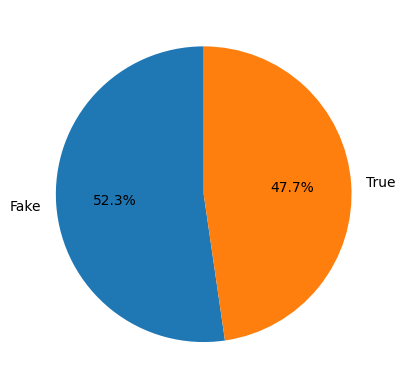

In [10]:

label_size = total_news['label'].value_counts()

print(label_size)

plt.pie(label_size,
        startangle=90,  # start angle of the pie chart
        labels=['Fake', 'True'],
        autopct='%1.1f%%')

plt.show()


In [26]:
from sklearn.model_selection import train_test_split

# split = 80% training 20% testing
train_data, test_data = train_test_split(total_news, test_size=0.2, random_state=42)

# test data = 50% test, 50% val
val_data, test_data = train_test_split(test_data, test_size=0.5, random_state=42)


In [13]:
# load BERT model for binary classificaition

bert = AutoModel.from_pretrained('bert-base-uncased', num_labels=2)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Text(0, 0.5, 'Number of Texts')

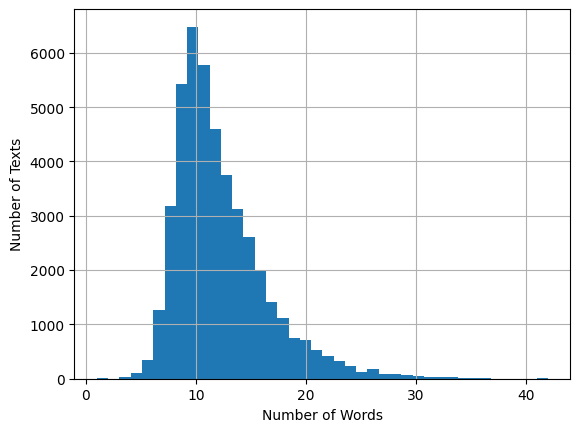

In [14]:
seq_len = [len(i.split()) for i in total_news['title']]
pd.Series(seq_len).hist(bins=40)

plt.xlabel('Number of Words')
plt.ylabel('Number of Texts')

In [15]:
MAX_LENGTH = 18 # max words in title

# initialize pretrained tokenizer to split the text into tokens. input = text, output = numbers the model can understand

tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

def tokenize_text(text_data, max_length = MAX_LENGTH):

  return tokenizer.batch_encode_plus(

      text_data.tolist(), # ensure input is a list, not panda series. batch_encode_plus requires list or tuple of strings
      max_length = max_length,
      padding = 'max_length',
      truncation = True,
      return_tensors='pt',
      return_token_type_ids = False, # used in sentence pair tasks
      return_attention_mask = True, # attention masks are for transformer models
      add_special_tokens = True # add [CLS] = token to indicate start of input seq, [SEP] = token to indicate end of seq
  )

tokens_train = tokenize_text(total_news['title'], MAX_LENGTH)
tokens_val = tokenize_text(total_news['title'], MAX_LENGTH)
tokens_test = tokenize_text(total_news['title'], MAX_LENGTH)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [45]:
'''
convert tokenized text into pytorch tensors to train BERT model. Pytorch needs structured format(list) to properly create the tensor and allocate memory

2d list(list of lists) w each inner list corresponding to tokenized sequence of single text: token id

outer list holds multiple sequences (one for each text sample). inner list holds the token IDs for each sequence.

If you want to create a new tensor with a new memory allocation use .clone() and .detach() to create a copy of the tensor in a new memory space.
Warning occurred bc new tensor being created by directly referencing data in memory w/o creating new memory block for new tensor

when creating new tensor, esp using method = torch.tensor(existing_tensor) PyTorch does not always create a new independent memory block.
Instead, it might share memory between the new tensor and the original tensor, meaning both tensors point to the same data in memory.
'''

# ensure the input is in list form (if it's a Pandas Series, convert it to a list)
train_seq = torch.tensor(tokens_train['input_ids'].tolist(), dtype=torch.long).clone().detach()
train_mask = torch.tensor(tokens_train['attention_mask'].tolist(), dtype=torch.long).clone().detach() # specify long because pytorch uses default torch.float32 and BERT uses integers not floats
train_y = torch.tensor(total_news['label'].values, dtype=torch.long).clone().detach() # .values converts to pd series into np array and removes each element's idx.

# Use `.tolist()` for tokenized sequences (to maintain list of lists structure) and `.values` for 1D arrays (like labels, to convert to NumPy array).

val_seq = torch.tensor(tokens_val['input_ids'].tolist(), dtype=torch.long).clone().detach()
val_mask = torch.tensor(tokens_val['attention_mask'].tolist(), dtype=torch.long).clone().detach()
val_y = torch.tensor(total_news['label'].values, dtype=torch.long).clone().detach()

test_seq = torch.tensor(tokens_test['input_ids'].tolist(), dtype=torch.long).clone().detach()
test_mask = torch.tensor(tokens_test['attention_mask'].tolist(), dtype=torch.long).clone().detach()
test_y = torch.tensor(total_news['label'].values, dtype=torch.long).clone().detach()



In [31]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

batch_size = 32

train_data = TensorDataset(train_seq, train_mask, train_y) # wrap the 3 tensors into single object
train_sampler = RandomSampler(train_data)  # random sampling for training set
train_dataloader = DataLoader(
    train_data,
    sampler=train_sampler,
    batch_size=batch_size,
    pin_memory=True           # pin memory for faster data transfer from CPU to GPU
)

val_data = TensorDataset(val_seq, val_mask, val_y)
val_sampler = SequentialSampler(val_data)  # sequential sampling for validation set
val_dataloader = DataLoader(
    val_data,
    sampler=val_sampler,
    batch_size=batch_size,
    pin_memory=True
)


test_data = TensorDataset(test_seq, test_mask, test_y)
test_sampler = SequentialSampler(test_data)  # sequential sampling for test set
test_dataloader = DataLoader(
    test_data,
    sampler=test_sampler,
    batch_size=batch_size,
    pin_memory=True
)

In [32]:
# freeze all BERT parameters
for param in bert.parameters():
  param.requires_grad = False

In [33]:
import torch.nn as nn
from transformers import BertModel, AdamW

class BERT_Arch(nn.Module):
    def __init__(self, bert):
        super(BERT_Arch, self).__init__() # super() to call method from parent class(superclass) inside child class since BERT_Arch inheriting from nn.Module class
        self.bert = bert
        self.fc1 = nn.Linear(768, 512)
        self.fc2 = nn.Linear(512, 2)
        self.dropout = nn.Dropout(0.1)  # dropout layer for regularization (prevent overfitting and model too dependent on certain neurons)
        self.relu = nn.ReLU()  # relu activation for non-linearity (neg values = 0) and fix vanishing gradient

    def forward(self, title_id, mask):
        outputs = self.bert(title_id, attention_mask=mask)

        ''' [CLS] token represents entire sequence(sentence) after being processed by the model.
        = first token's hidden state. the token's hidden state is extracted for every sentence(all tokens) in the batch and stored in cls_hs.
        the hidden state of the [CLS] token is used to make predictions ab the entire input seq bc it is a compressed representation of the input.

        '''
        cls_hs = outputs.last_hidden_state[:, 0, :]   # results in 2d tensor: [batch_size, hidden_size]

        x = self.fc1(cls_hs)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)  # output layer (raw logits = scores of each class --> unnormalized prediction b4 applying activation functions softmax or sigmoid)

        return x  # return raw logits (CrossEntropyLoss requires raw logits)

bert = BertModel.from_pretrained('bert-base-uncased')

model = BERT_Arch(bert)

''' cuda = parallel computing platform made by nvidia that enables gpu usage

same as:
device = torch.device("cuda")
model.to(device)

'''
model = model.cuda() # if available, move model to gpu

optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5) # adjusts learning rate for each parameter, using gradients to update the parameters

cross_entropy = nn.CrossEntropyLoss() # applies sigmoid(since binary classification so not softmax) activation. Sigmoid converts raw logits into probabilities.

epochs = 1


In [34]:
def train():

    total_loss, total_accuracy = 0, 0
    model.train()

    for step, batch in enumerate(train_dataloader):

        batch = [r.to(device) for r in batch] # for each tensor t in the batch, move input to device that is training the model so both model and input data on same device
        sent_id, mask, labels = batch
        model.zero_grad() # clear gradients from after each batch
        preds = model(sent_id, mask) # prediction based of input sentence id and mask
        loss = cross_entropy(preds, labels)
        total_loss += loss.item() #loss.item() extracts numerical value of loss from the tensor

        # caluclate accuracy
        preds = np.argmax(preds.detach().cpu().numpy(), axis=1) # converts preds from model into class labels by selecting the class with highest probability for each sample.
        # detach() removes tensor cpu().numpy() moves tensor to cpu and convert to np arry
        accuracy = np.sum(preds == labels.detach().cpu().numpy()) / len(labels)
        total_accuracy += accuracy

        loss.backward() # computes gradients by backprop
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0) # gradient clipping: prevent gradients from exploding. gradient limited to max norm = 1.0
        optimizer.step() # updates model's weights based on gradients from backprop. decides how to adjust weights to reduce loss

    avg_loss = total_loss / len(train_dataloader)
    avg_accuracy = total_accuracy / len(train_dataloader)

    return avg_loss, avg_accuracy


def evaluate():
    print("\nEvaluating...")
    model.eval()
    total_loss, total_accuracy = 0, 0

    for step, batch in enumerate(val_dataloader):

        batch = [t.to(device) for t in batch]
        sent_id, mask, labels = batch

        with torch.no_grad(): # make predictions without gradients, saving memory and computation time
            preds = model(sent_id, mask)
            loss = cross_entropy(preds, labels)
            total_loss += loss.item()

            preds = np.argmax(preds.detach().cpu().numpy(), axis=1)
            accuracy = np.sum(preds == labels.detach().cpu().numpy()) / len(labels)
            total_accuracy += accuracy

    avg_loss = total_loss / len(val_dataloader)
    avg_accuracy = total_accuracy / len(val_dataloader)

    return avg_loss, avg_accuracy


In [46]:
from torch.amp import GradScaler, autocast
scaler = GradScaler()


In [25]:
train_losses = []
val_losses = []

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

for epoch in range(epochs):
    print(f'\nEpoch {epoch + 1}/{epochs}')

    model.train()  # set the model to training mode
    total_train_loss = 0
    total_train_accuracy = 0
    for batch in train_dataloader:
        batch = [r.to(device) for r in batch]
        sent_id, mask, labels = batch

        optimizer.zero_grad()  # clear gradients

        # mixed precision: use autocast for forward pass
        with autocast():
            preds = model(sent_id, mask)
            loss = cross_entropy(preds, labels)

        # scaler: scale the loss and backpropagate
        scaler.scale(loss).backward()
        scaler.step(optimizer)  # update the model parameters
        scaler.update()  # update the scaler

        total_train_loss += loss.item()

        # calculate accuracy
        preds = np.argmax(preds.detach().cpu().numpy(), axis=1)
        accuracy = np.sum(preds == labels.detach().cpu().numpy()) / len(labels)
        total_train_accuracy += accuracy

    avg_train_loss = total_train_loss / len(train_dataloader)
    avg_train_accuracy = total_train_accuracy / len(train_dataloader)

    model.eval()  # set the model to evaluation mode
    total_val_loss = 0
    total_val_accuracy = 0
    for batch in val_dataloader:
        batch = [r.to(device) for r in batch]
        sent_id, mask, labels = batch

        with torch.no_grad():
            # autocast for forward pass
            with autocast():
                preds = model(sent_id, mask)
                loss = cross_entropy(preds, labels)

            total_val_loss += loss.item()

            # calculate accuracy
            preds = np.argmax(preds.detach().cpu().numpy(), axis=1)
            accuracy = np.sum(preds == labels.detach().cpu().numpy()) / len(labels)
            total_val_accuracy += accuracy

    avg_val_loss = total_val_loss / len(val_dataloader)
    avg_val_accuracy = total_val_accuracy / len(val_dataloader)

    print(f'Training Loss: {avg_train_loss:.3f} | Training Accuracy: {avg_train_accuracy:.3f}')
    print(f'Validation Loss: {avg_val_loss:.3f} | Validation Accuracy: {avg_val_accuracy:.3f}')

    train_losses.append((avg_train_loss, avg_train_accuracy))
    val_losses.append((avg_val_loss, avg_val_accuracy))



Epoch 1/1


<ipython-input-25-69b7925b5d7d>:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-25-69b7925b5d7d>:47: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Training Loss: 0.029 | Training Accuracy: 0.990
Validation Loss: 0.011 | Validation Accuracy: 0.996


In [27]:
torch.cuda.empty_cache()  # clear unused memory from the GPU


In [28]:
preds = []
chunk_size = 32
for i in range(0, len(test_seq), chunk_size):
    batch_seq = test_seq[i:i+chunk_size].to(device)
    batch_mask = test_mask[i:i+chunk_size].to(device)

    with torch.no_grad():
        batch_preds = model(batch_seq, batch_mask)
        batch_preds = batch_preds.detach().cpu().numpy()
        preds.extend(np.argmax(batch_preds, axis=1))

preds = np.array(preds)

print(classification_report(test_y, preds))

              precision    recall  f1-score   support

           0       1.00      0.99      1.00     23481
           1       0.99      1.00      1.00     21417

    accuracy                           1.00     44898
   macro avg       1.00      1.00      1.00     44898
weighted avg       1.00      1.00      1.00     44898

